In [42]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install pandas mysql-connector-python matplotlib seaborn geopandas


In [44]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [45]:
import mysql.connector
import pandas as pd

# Connect to MySQL database
conn = mysql.connector.connect(
    host="Localhost",
    user="root",
    password="gowtham2003",
    database="crime"
)

# Query the dataset
query = "SELECT * FROM china_crime"
df = pd.read_sql(query, conn)


C:\Users\gowth\AppData\Local\Temp\ipykernel_7956\533320901.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [46]:
df.head()

,Crime_ID,Crime_Type,Location,Date,Time,Victim_Age,Suspect_Age,Weapon_Used,Latitude,Longitude
0,1001,Burglary,Shenzhen,2024-01-01,00:00,63,30,Unknown,27.490802,103.702659
1,1002,Fraud,Wuhan,2024-01-01,00:01,47,59,Unknown,39.014286,110.838019
2,1003,Burglary,Beijing,2024-01-01,00:02,57,20,Unknown,34.639879,117.458917
3,1004,Assault,Chongqing,2024-01-02,00:04,35,26,Knife,31.973170,114.644498
4,1005,Assault,Shenzhen,2024-01-02,00:05,68,29,None,23.120373,116.131223


In [47]:
df["Weapon_Used"]=df["Weapon_Used"].replace("Unknown","unspecified")

In [48]:
df.head()

,Crime_ID,Crime_Type,Location,Date,Time,Victim_Age,Suspect_Age,Weapon_Used,Latitude,Longitude
0,1001,Burglary,Shenzhen,2024-01-01,00:00,63,30,unspecified,27.490802,103.702659
1,1002,Fraud,Wuhan,2024-01-01,00:01,47,59,unspecified,39.014286,110.838019
2,1003,Burglary,Beijing,2024-01-01,00:02,57,20,unspecified,34.639879,117.458917
3,1004,Assault,Chongqing,2024-01-02,00:04,35,26,Knife,31.973170,114.644498
4,1005,Assault,Shenzhen,2024-01-02,00:05,68,29,None,23.120373,116.131223


In [49]:
df.isnull().sum()

Crime_ID       0
Crime_Type     0
Location       0
Date           0
Time           0
Victim_Age     0
Suspect_Age    0
Weapon_Used    0
Latitude       0
Longitude      0
dtype: int64

In [50]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Fill or drop missing values based on relevance
df = df.dropna()  # Optionally fill with mean or median values based on context

# Convert Date and Time columns to proper datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.time

# Remove duplicate rows, if any
df = df.drop_duplicates()

# Verify data types
print("Data types:\n", df.dtypes)


Missing values:
 Crime_ID       0
Crime_Type     0
Location       0
Date           0
Time           0
Victim_Age     0
Suspect_Age    0
Weapon_Used    0
Latitude       0
Longitude      0
dtype: int64
Data types:
 Crime_ID                int64
Crime_Type             object
Location               object
Date           datetime64[ns]
Time                   object
Victim_Age              int64
Suspect_Age             int64
Weapon_Used            object
Latitude              float64
Longitude             float64
dtype: object


          Crime_ID                        Date   Victim_Age  Suspect_Age  \
count  1000.000000                        1000  1000.000000  1000.000000   
mean   1500.500000  2024-07-01 00:01:26.400000    43.582000    43.964000   
min    1001.000000         2024-01-01 00:00:00    18.000000    18.000000   
25%    1250.750000         2024-03-31 18:00:00    31.000000    31.000000   
50%    1500.500000         2024-07-01 00:00:00    43.000000    43.000000   
75%    1750.250000         2024-09-30 06:00:00    57.000000    57.000000   
max    2000.000000         2024-12-31 00:00:00    69.000000    69.000000   
std     288.819436                         NaN    14.778555    14.783411   

          Latitude    Longitude  
count  1000.000000  1000.000000  
mean     29.805131   110.140346  
min      20.092640   100.064365  
25%      24.719465   104.821485  
50%      29.936148   110.374678  
75%      34.886392   115.209301  
max      39.994353   119.988275  
std       5.842747     5.843798  


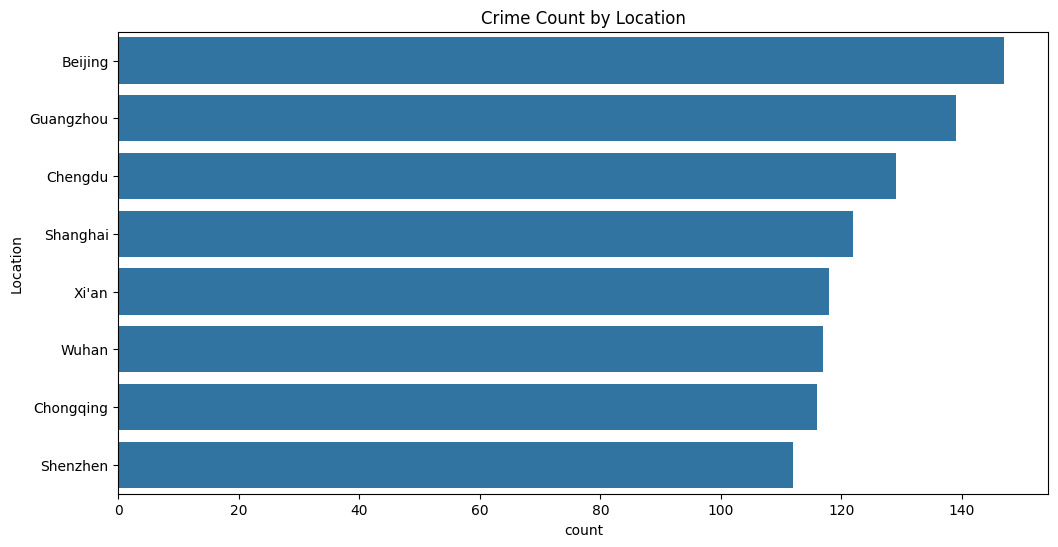

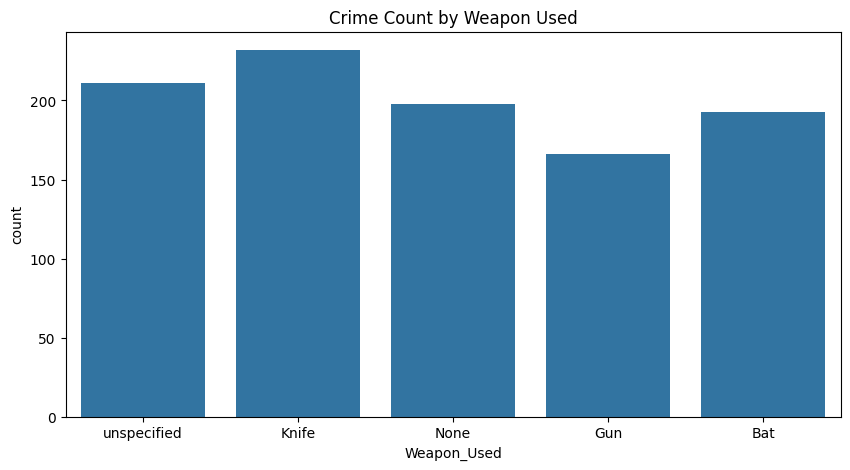

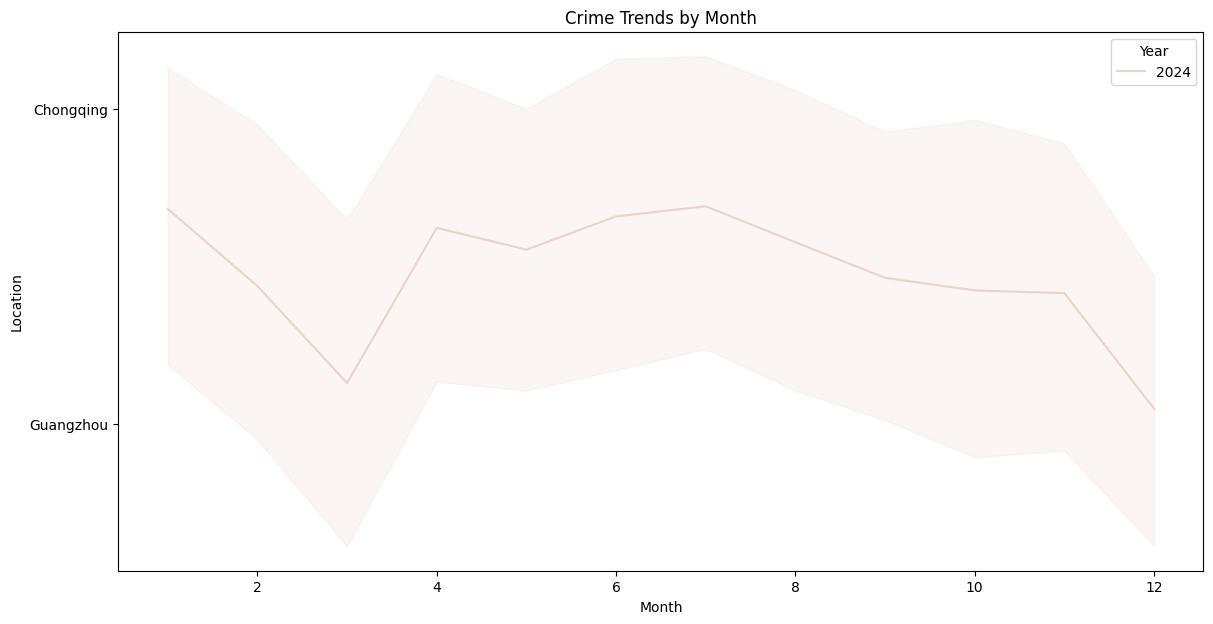

In [51]:


# Basic statistics
print(df.describe())

# Crime count by Location
plt.figure(figsize=(12, 6))
sns.countplot(y='Location', data=df, order=df['Location'].value_counts().index)
plt.title('Crime Count by Location')
plt.show()

# Distribution of crime types (assuming Weapon_Used indicates crime types)
plt.figure(figsize=(10, 5))
sns.countplot(x='Weapon_Used', data=df)
plt.title('Crime Count by Weapon Used')
plt.show()

# Crime trends over time
plt.figure(figsize=(14, 7))
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
sns.lineplot(x='Month', y='Location', data=df, hue='Year')
plt.title('Crime Trends by Month')
plt.show()


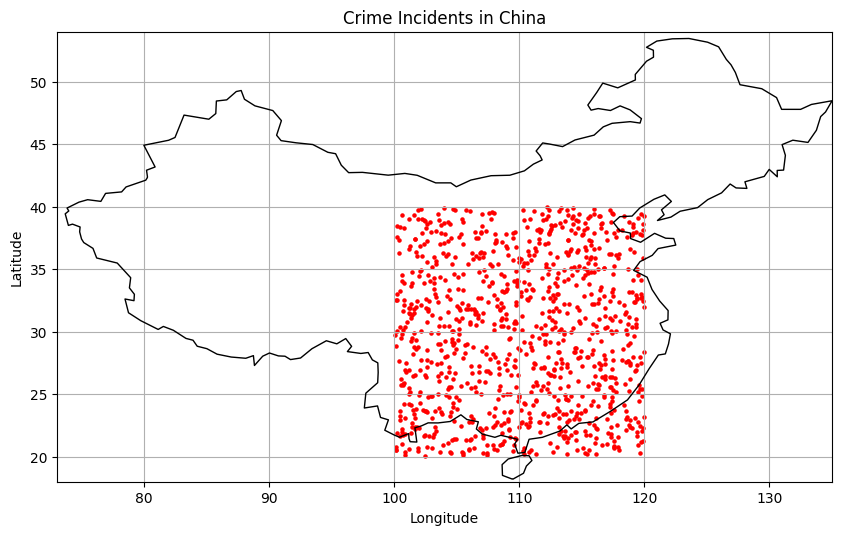

In [52]:

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Load the shapefile of the world map (ensure to specify the correct path)
shapefile_path = r"C:\Users\gowth\Downloads\110m_cultural\ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

# Filter to get only China
china = world[world['ADMIN'] == 'China']

# Create the plot for crime incidents
fig, ax = plt.subplots(figsize=(10, 10))
china.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot China boundaries
geo_df.plot(ax=ax, color='red', markersize=5)           # Plot crime incidents

# Set titles and labels
plt.title('Crime Incidents in China')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(73, 135)  # Approximate longitude bounds of China
plt.ylim(18, 54)   # Approximate latitude bounds of China
plt.grid()
plt.show()

# Create a map using folium
m = folium.Map(location=[35.0, 105.0], zoom_start=5)

# Define color mapping for different crime types
crime_colors = {
    'Theft': 'blue',
    'Assault': 'red',
    'Burglary': 'green',
    'Fraud': 'purple',
    'Vandalism': 'orange',
    # Add more crime types and colors as needed
}

# Calculate the total number of incidents
total_incidents = len(df)

# Calculate the crime rates
crime_rate = df['Crime_Type'].value_counts(normalize=True) * 100  # in percentage

# Add markers for each crime incident
for index, row in df.iterrows():
    crime_type = row['Crime_Type']
    crime_rate_value = crime_rate[crime_type] if crime_type in crime_rate else 0.0  # Default to 0 if not found
    color = crime_colors.get(crime_type, 'gray')  # Default to gray if crime type not found

    # Create a marker with a tooltip
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Crime Type: {crime_type}<br>Crime Rate: {crime_rate_value:.2f}%",
        icon=folium.Icon(color=color)
    ).add_to(m)

# Save the map to an HTML file
m.save('crime_locations_map_with_rates.html')

# Display the map (if you're in a Jupyter Notebook)
m

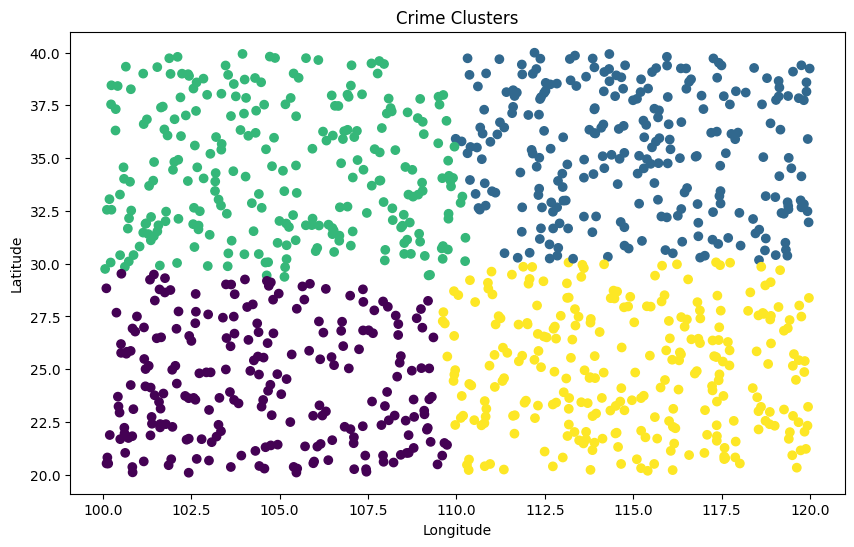

In [53]:
from sklearn.cluster import KMeans


# K-Means clustering based on location
location_data = df[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=4, random_state=0).fit(location_data)
df['Cluster'] = kmeans.labels_

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], cmap='viridis')
plt.title('Crime Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Basic Statistics:
count    366.000000
mean       2.732240
std        0.449534
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
dtype: float64


c:\Users\gowth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gowth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gowth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


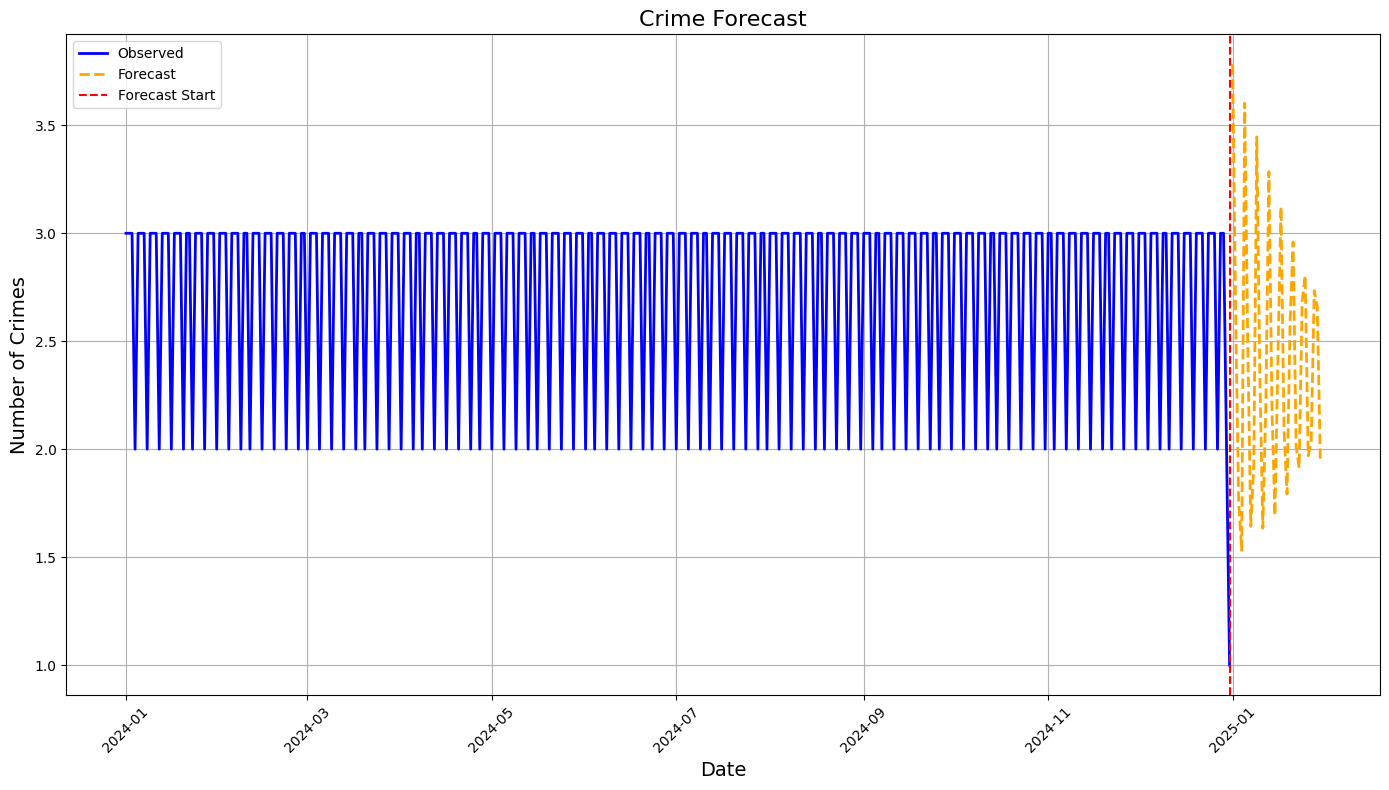

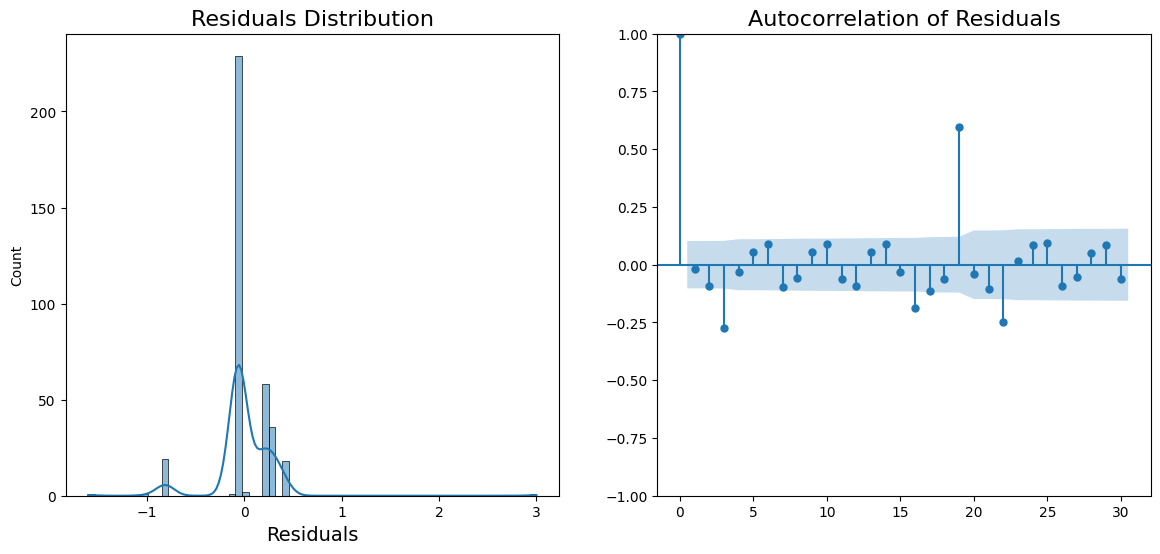

<Figure size 1200x600 with 0 Axes>

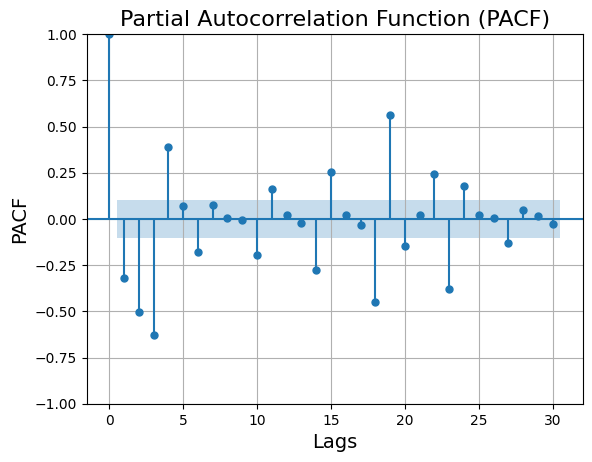

In [54]:



# Assuming df is your DataFrame containing the crime data
# Ensure the 'Date' column is a datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Create a date-wise count of crimes, grouping by Date
date_wise_crimes = df.groupby('Date').size()

# Ensure the index of date_wise_crimes is a DatetimeIndex
date_wise_crimes.index = pd.to_datetime(date_wise_crimes.index)

# Display basic statistics of the crime data
print("Basic Statistics:")
print(date_wise_crimes.describe())

# Build and fit ARIMA model
model = ARIMA(date_wise_crimes, order=(5, 1, 0))
model_fit = model.fit()

# Forecast future crime trends
forecast = model_fit.forecast(steps=30)

# Create a date range for the forecasted period
forecast_dates = pd.date_range(start=date_wise_crimes.index[-1] + pd.Timedelta(days=1), periods=30)

# Convert forecast to a Pandas Series with the new index
forecast_series = pd.Series(forecast, index=forecast_dates)

# Plotting observed data and forecast
plt.figure(figsize=(14, 8))
plt.plot(date_wise_crimes, label='Observed', color='blue', linewidth=2)
plt.plot(forecast_series, label='Forecast', color='orange', linestyle='--', linewidth=2)
plt.title('Crime Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.axvline(x=date_wise_crimes.index[-1], color='red', linestyle='--', label='Forecast Start', linewidth=1.5)
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual Analysis
residuals = model_fit.resid

# Plot Residuals
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution', fontsize=16)
plt.xlabel('Residuals', fontsize=14)

plt.subplot(1, 2, 2)
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title('Autocorrelation of Residuals', fontsize=16)
plt.show()

# Plotting PACF
plt.figure(figsize=(12, 6))
plot_pacf(date_wise_crimes, lags=30)
plt.title('Partial Autocorrelation Function (PACF)', fontsize=16)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('PACF', fontsize=14)
plt.grid()
plt.show()


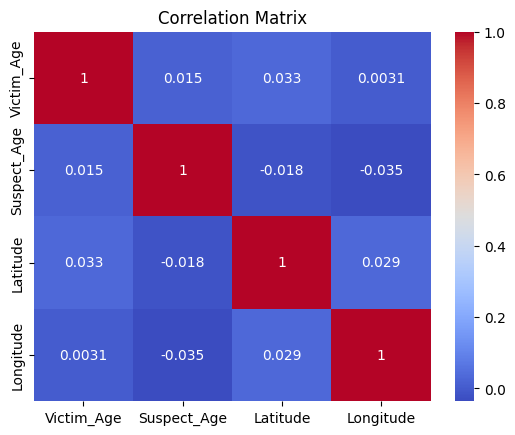

In [55]:
# Check correlation between numeric fields
corr = df[['Victim_Age', 'Suspect_Age', 'Latitude', 'Longitude']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Prepare data for classification
X = df[['Victim_Age', 'Suspect_Age', 'Latitude', 'Longitude']]
y = df['Weapon_Used']  # Assuming 'Weapon_Used' represents crime types

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.19
              precision    recall  f1-score   support

         Bat       0.28      0.24      0.26        62
         Gun       0.07      0.06      0.06        50
       Knife       0.24      0.29      0.26        68
        None       0.12      0.13      0.12        53
 unspecified       0.21      0.18      0.19        67

    accuracy                           0.19       300
   macro avg       0.18      0.18      0.18       300
weighted avg       0.19      0.19      0.19       300

